In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)


import numpy as np

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import GaussianUnknownMean, SMGaussianUnknownMean, DSMGaussianUnknownMean
from generate_data import generate_data

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/computation')

# synthetic dataset

In [3]:
np.random.seed(4574)

T      = 2000 # Number of observations.
hazard = ConstantHazard(400)
mean0  = 0      # The prior mean on the mean parameter.
var0   = 5 
# The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps  = generate_data(varx, mean0, var0, T, hazard)
data = np.array(data)
contamination = np.random.choice(np.arange(T),size=20)
data[contamination] = data[contamination] + np.random.normal(loc=0,scale=60)


### BOCPD

In [4]:
model  = GaussianUnknownMean(mean0, var0, varx)

In [7]:
import time
N = 100
times_BOCD = []
for i in range(N):
    model  = GaussianUnknownMean(mean0, var0, varx)
    start_time = time.time()
    bocpd(data, hazard, model)
    end_time = time.time()
    times_BOCD.append(end_time-start_time)

In [6]:
np.mean(times_BOCD),np.std(times_BOCD) 

(1.6652102327346803, 0.08016122919963092)

In [5]:
R_BOCP  = bocpd(data, hazard, model)

In [6]:
def find_CPs(R, lag = 20):
    n = len(R)
    CPs = [0]
    last_CP = 0
    for i in range(n):
        candidate = i-np.argmax(R[i,:])
        if candidate > last_CP+lag:
            if (candidate not in CPs):
                CPs.append(candidate)
                last_CP = np.max(CPs)
        if candidate < last_CP:
            try:
                CPs.remove(last_CP)
                last_CP = np.max(CPs)
            except:
                pass
    return CPs

In [7]:
cps_BOCP = find_CPs(R_BOCP)

### DSM-BOCPD

In [17]:
def grad_r(x):
    return np.eye(1)/varx

def grad_b(x):
    return -x/varx

def lap_r(x):
    return np.zeros(1)

data = np.array(data).reshape([T,1])
beta = 0.0001

model = SMGaussianUnknownMean(data, grad_t, lap_t, grad_b, beta, mean0, var0, varx)

In [10]:
import time
N = 100
times_DSM = []
for i in range(N):
    model = SMGaussianUnknownMean(data, grad_t, lap_t, grad_b, beta, mean0, var0, varx)
    start_time = time.time()
    bocpd(data, hazard, model)
    end_time = time.time()
    times_DSM.append(end_time-start_time)

In [11]:
np.mean(times_DSM),np.std(times_DSM) 

(1.7987284970283508, 0.13603772509077078)

In [18]:
R_DSM = bocpd(data, hazard, model)

In [19]:
cps_DSM = find_CPs(R_DSM)

/tmp/ipykernel_21254/171759323.py:26: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


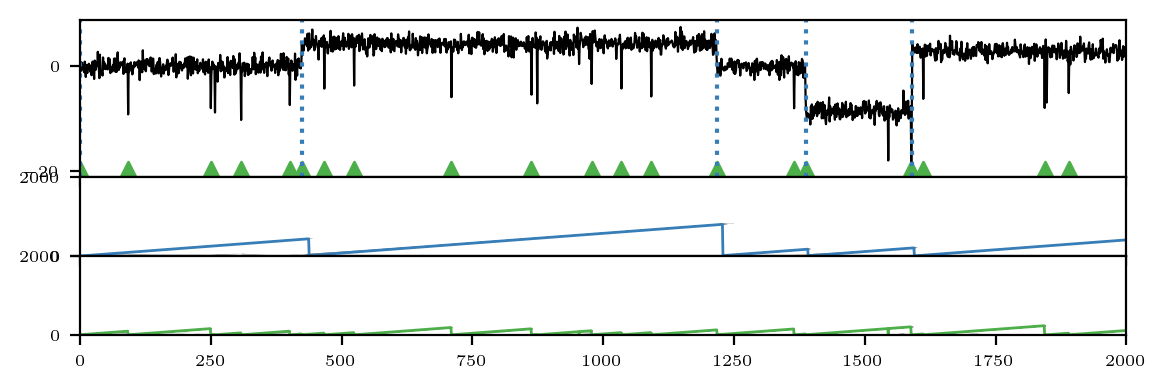

In [28]:
FILE_NAME = 'Computation.pdf'

with plt.rc_context(bundles.icml2022(column='full', ncols=2)):

    fig, ax = plt.subplots(3, 1, sharex = True , gridspec_kw={'height_ratios': [2,1,1]}, dpi = 200)
    ax[0].plot(data[:,0],c='black',lw=0.8)
    y_lims = ax[0].get_ylim()
    
    ax[1].set_ylim([0,T])
    ax[1].imshow(np.rot90(R_DSM), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[1].plot(np.argmax(R_DSM[1:],axis=1), c=CB_color_cycle[0], alpha=1, lw=1)
    
    ax[2].set_ylim([0,T])
    ax[2].imshow(np.rot90(R_BOCP), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R_BOCP[1:],axis=1), c=CB_color_cycle[2], alpha=1, lw=1)

    for cp in cps_DSM:
        ax[0].axvline(cp, c=CB_color_cycle[0], ls='dotted', lw=1.5)
        
    for cp in cps_BOCP:
        ax[0].scatter(cp, y_lims[0], marker="^", c=CB_color_cycle[2],alpha=1, lw=1)
    
   
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")